<a href="https://colab.research.google.com/github/polrib/NeuralNetworksCourse/blob/main/SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Neural Networks for Data Science Aplications**

Reference Paper: **Learning Structured Sparsity in Deep Neural
Networks**

#### Motivation of the paper:
The aim of the paper is to propose a regularization method called Structured Sparsity Learning (SSL) that regularizes filters, channels, filter shapes, and layer depth) of DNNs. SSL advantages are first to learn a compact structure from a bigger DNN in order to reduce computation cost; and obtain a hardware-friendly structured sparsity of DNN to efficiently accelerate
the DNN’s evaluation.

### SETUP

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.regularizers import Regularizer
from keras import backend as K
from keras.constraints import Constraint

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

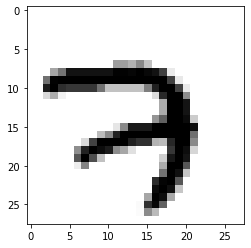

In [ ]:
plt.imshow(X_train[0], cmap='binary')

In [ ]:
X_train=X_train.reshape(X_train.shape[0],28,28,1)
X_valid=X_valid.reshape(X_valid.shape[0],28,28,1)
X_test=X_test.reshape(X_test.shape[0],28,28,1)

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (28, 28, 1)


### REGULARIZERS

In [ ]:
class MyRegularizer(regularizers.Regularizer):

    def __init__(self, strength=0.01):
        self.strength = tf.keras.backend.cast(strength, dtype='float32')

    def __call__(self, x):
           return self.strength * tf.reduce_sum(tf.square(x))+self.strength*K.sum(K.sqrt(K.sum(K.square(x), axis=0)))
          
    def get_config(self):
        return {'strength': float(self.strength)}
    

In [ ]:
class Penalizing(regularizers.Regularizer):

    def __init__(self, strength=0.01):
        self.strength = tf.keras.backend.cast(strength, dtype='float32')

    def __call__(self, x):
           return self.strength*K.sum(K.sqrt(K.sum(K.square(x), axis=3)))+self.strength*K.sum(K.sqrt(K.sum(K.square(x), axis=2)))
          
    def get_config(self):
        return {'strength': float(self.strength)}

In [ ]:
class Learning_shapes(regularizers.Regularizer):

    def __init__(self, strength=0.01):
        self.strength = tf.keras.backend.cast(strength, dtype='float32')

    def __call__(self, x):
           return self.strength*K.sum(K.sqrt(K.sum(K.square(x), axis=[0,1,2])))
          
    def get_config(self):
        return {'strength': float(self.strength)}

In [ ]:

# Utility function to count active neurons in a Keras model with Dense layers
def count_neurons(model):
    return np.sum([np.sum(np.sum(np.abs(l.get_weights()[0]), axis=2) > 10**-3) 
                          for l in model.layers if 'conv' in l.name])

# Callback class to save training loss and the number of neurons
class History(keras.callbacks.Callback):

    losses=[]
    neurons=[]
    def on_train_begin(self, logs={}):
        self.losses = []
        self.neurons = [count_neurons(self.model)]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs['loss'])
        self.neurons.append(count_neurons(self.model))

### TRAINING

In [ ]:
n_epochs = 15
batch_size = 64
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.Adam(lr=0.01)
initializer=tf.keras.initializers.GlorotNormal()
bias_filler=tf.keras.initializers.constant()

In [ ]:
baseline_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
l2_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
gl_model = keras.models.Sequential([
    #tf.keras.layers.Masking(mask_value=0.0,input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_regularizer=MyRegularizer(0.001), kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    #tf.keras.layers.Masking(mask_value=0),
    keras.layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_regularizer=MyRegularizer(0.001),kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(input_shape=[28, 28]),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(500, activation='relu',kernel_initializer=initializer, bias_initializer=bias_filler),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(10, activation="softmax",kernel_initializer=initializer, bias_initializer=bias_filler)
])

In [ ]:
penalize_model = keras.models.Sequential([
    #tf.keras.layers.Masking(mask_value=0.0,input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_regularizer=Penalizing(0.001), kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    #tf.keras.layers.Masking(mask_value=0),
    keras.layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_regularizer=Penalizing(0.001),kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(input_shape=[28, 28]),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(500, activation='relu',kernel_initializer=initializer, bias_initializer=bias_filler),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(10, activation="softmax",kernel_initializer=initializer, bias_initializer=bias_filler)
])

In [ ]:
filers_model = keras.models.Sequential([
    #tf.keras.layers.Masking(mask_value=0.0,input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_regularizer=Learning_shapes(0.001), kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    #tf.keras.layers.Masking(mask_value=0),
    keras.layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_regularizer=Learning_shapes(0.001),kernel_initializer=initializer, bias_initializer=bias_filler),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(input_shape=[28, 28]),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(500, activation='relu',kernel_initializer=initializer, bias_initializer=bias_filler),
    #tf.keras.layers.Masking(mask_value=0.0),
    keras.layers.Dense(10, activation="softmax",kernel_initializer=initializer, bias_initializer=bias_filler)
])

In [ ]:
baseline_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 50)          25050     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               400500    
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
baseline_model.compile(loss=loss_fn, metrics=['accuracy'])

hist=History()

# a = np.array(model.get_layer(index=0).get_weights())         # save weights in a np.array of np.arrays
# # # weights = model.get_layer(index=3).get_weights()

# sparsified_weights = []
# threshold = 10**-3

# for w in a:
#   bool_mask = (w > threshold).astype(int)
#   sparsified_weights.append(w*bool_mask)

# model.get_layer(index=0).set_weights(sparsified_weights)



# #model.get_layer(index=3).set_weights(np.where(a > 1.3, a, 0))                  # add 1 to all weights in the neural network
# #b = np.array(model.get_layer(index=3).get_weights())         # save weights a second time in a np.array of np.arrays
#print(sparsified_weights - a) 

In [ ]:
%timeit
import time
start_time = time.time()

history = baseline_model.fit(X_train, y_train, epochs=n_epochs,  batch_size=64, validation_data=(X_valid, y_valid),callbacks=[hist])

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/15
860/860 [==============================] - 3s 3ms/step - loss: 0.1644 - accuracy: 0.9491 - val_loss: 0.0732 - val_accuracy: 0.9804
Epoch 2/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.0421 - val_accuracy: 0.9892
Epoch 3/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0349 - accuracy: 0.9894 - val_loss: 0.0405 - val_accuracy: 0.9886
Epoch 4/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0263 - accuracy: 0.9917 - val_loss: 0.0296 - val_accuracy: 0.9912
Epoch 5/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.0304 - val_accuracy: 0.9902
Epoch 6/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.0320 - val_accuracy: 0.9928
Epoch 7/15
860/860 [==============================] - 3s 3ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.0367 - val_accuracy: 0.9912
Epoch 

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0514 - accuracy: 0.9900


[0.05140416696667671, 0.9900000095367432]

### Analysis

In [ ]:
for layer in baseline_model.layers:
	# check for convolutional layer
	if 'average' in layer.name:
		continue
	elif 'flatten' in layer.name:
		continue
	elif 'masking' in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (5, 5, 1, 20)
conv2d_1 (5, 5, 20, 50)
dense (800, 500)
dense_1 (500, 10)


In [ ]:
def plot_neurons(models_list,names_list):
    for n, model in enumerate (models_list):
    # summarize history for accuracy
       # plt.plot(model.history.history['accuracy'])
        plt.plot(model)
        plt.title( names_list[n])
        plt.ylabel('Active neurons')
        plt.xlabel('Epoch')
    plt.legend([names_list[n-3],names_list[n-2],names_list[n-1],names_list[n]], loc='upper left')
    plt.show()



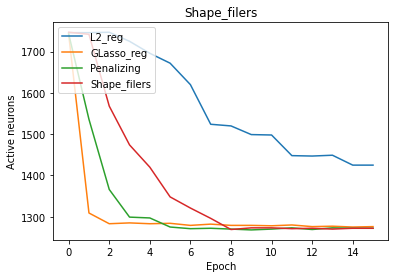

In [ ]:
plot_neurons([hist_l2, gl_hist, penalize_hist,fibers_hist],['L2_reg','GLasso_reg','Penalizing','Shape_filers'])

In [ ]:
#for n, model in enumerate(gl_model):
models_list=[baseline_model,l2_model,gl_model,penalize_model,filers_model]
#models_list=[gl_model]

names_list=['Baseline','L2','Glasso','FC','Filers']
#names_list=['glasso_reg']


def print_filters(model_list,names_list):
    for n,model in enumerate(models_list):

      filters = model.get_layer(index=2).get_weights()[0]
      fig = plt.figure(figsize=(26,8),facecolor='black')
      n_filters,ix=model.get_layer(index=0).get_weights()[0].shape[3],1
      

      for number in range(n_filters):
          f=filters[:,:,:,number]
          ax1 = fig.add_subplot(8,16,number+1)
          plt.title( names_list[n],color='white')
          ax1.imshow(f[:,:,0],cmap='gray')
          ax1.axis('off')
          plt.subplots_adjust(wspace=0.3, hspace=0.1,top=1.3)
    
    plt.show()

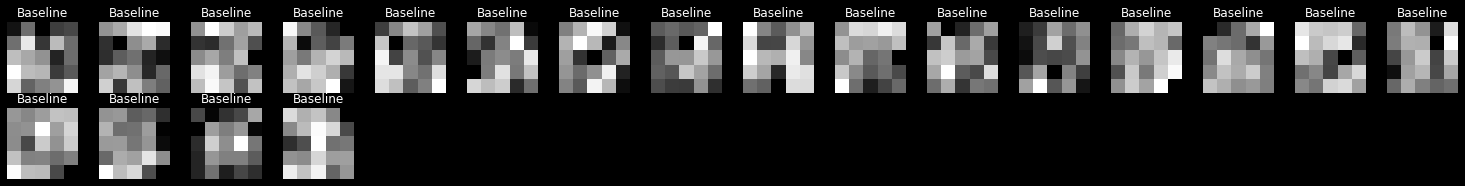

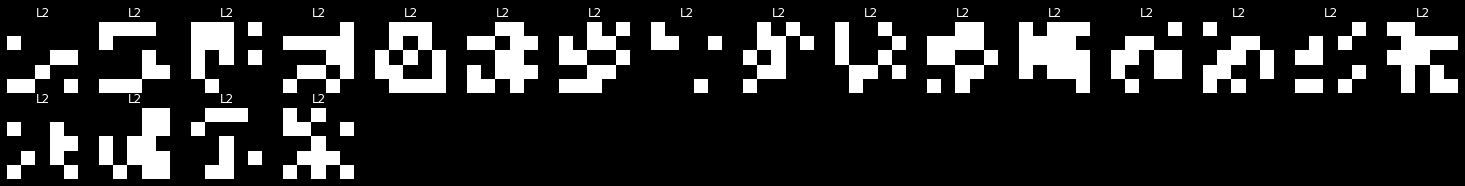

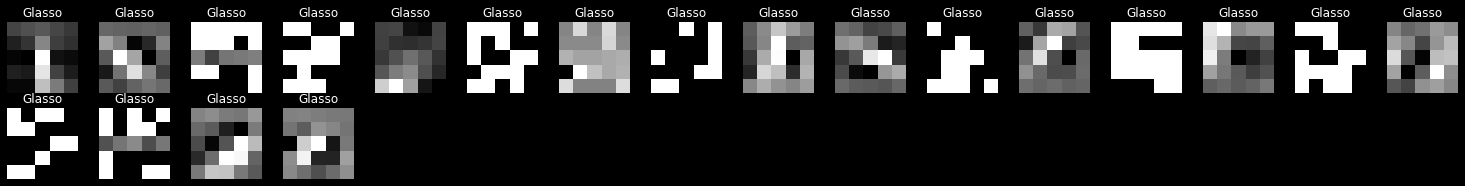

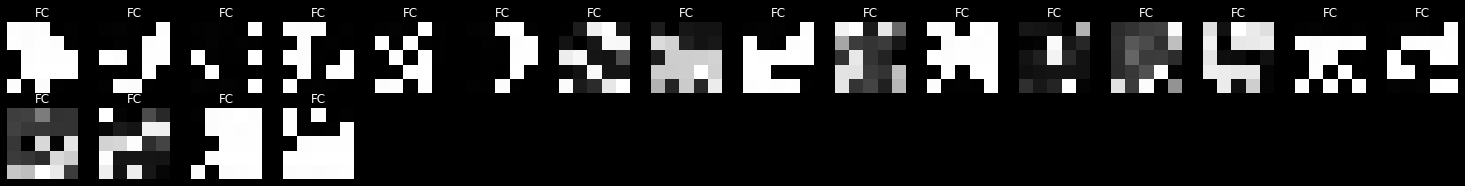

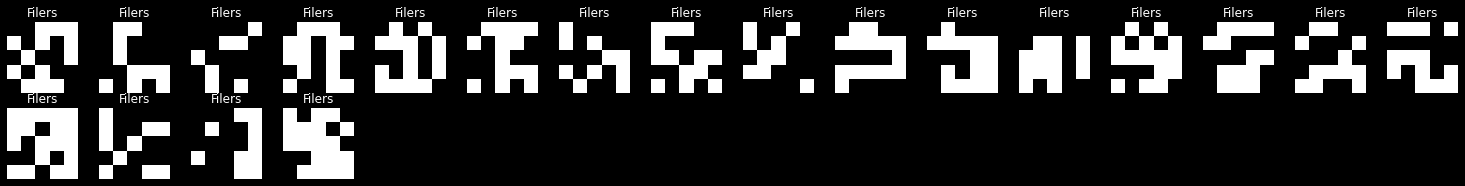

In [ ]:
print_filters(models_list,names_list)

Execution Times with different regularization:




1.   BASELINE: 40.31 secs
2.   L2: 42.022 secs
1.   Group Lasso: 48.65 secs
2.   Penalizing FC: 50.54 secs
2.   Shape Filers: 47.65 secs





